image.png

Data source web site :
[med-lter DB](https://med-lter.haifa.ac.il/index.php/en/data-base)

#**Photo Survey (Invertebrates**)

##Import libs and load Data

Load photo survey csv file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib as plt
import numpy as np
import datetime as dt
import seaborn as sns
import plotly.express as px
%matplotlib inline

from numpy.ma.core import right_shift

In [ ]:
#set max columns to 10
pd.set_option('display.max_columns', 20 )
pd.set_option('display.max_rows' , 40)
pd.options.display.max_rows

40

Load Fish survey

In [ ]:
fs = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/EDA Project/fishsurvey_sub.csv', parse_dates=['sample_date'])

Load Photo survey csv (inv)

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/EDA Project/photosurvey.csv"
photo_s = pd.read_csv(path, parse_dates = ['sample_date'])
photo_s.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92672 entries, 0 to 92671
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   site            92672 non-null  object        
 1   season          92672 non-null  object        
 2   depth           92672 non-null  int64         
 3   sample_date     92672 non-null  datetime64[ns]
 4   transect        92672 non-null  int64         
 5   name            92672 non-null  object        
 6   taxonomy_group  92672 non-null  object        
 7   image_name      92672 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 5.7+ MB


In [ ]:
photo_s.head()

,site,season,depth,sample_date,transect,name,taxonomy_group,image_name
0,Achziv10,Spring,10,2015-04-20,1,Shadow,Other,IMG_0735.JPG
1,Achziv10,Spring,10,2015-04-20,1,Turf,Algae,IMG_0735.JPG
2,Achziv10,Spring,10,2015-04-20,1,Turf,Algae,IMG_0735.JPG
3,Achziv10,Spring,10,2015-04-20,1,Turf,Algae,IMG_0735.JPG
4,Achziv10,Spring,10,2015-04-20,1,Turf,Algae,IMG_0735.JPG


###Data Transformation

In [ ]:
#same 'image_name' can have different rows
print(photo_s.image_name.value_counts().min() )
photo_s.image_name.value_counts().max()

16


16

In [ ]:
# add Columns
photo_s['sample_year'] = photo_s.sample_date.dt.year
photo_s['sample_month'] = photo_s.sample_date.dt.strftime('%Y-%m')
photo_s.rename({'name':'object_name' , 'site':'site_depth'} , axis = 1 , inplace= True)
photo_s['site'] = photo_s.site_depth.str[0:-2]

#drop values of taxonomy_group from rows
to_del = photo_s[photo_s.taxonomy_group.isin(['Soft Substrate' , 'Hard Substrate' , 'Other' ]) ]
photo_s.drop(to_del.index , inplace = True)

#drop rows from Sharom site
to_del = photo_s[ (photo_s.site == 'Sharon')  #| ( photo_s.sample_year.isin([2015, 2021]) )
                 ]
photo_s.drop(to_del.index , inplace = True)
#fix depth side for Ashdod30 (show 25)
photo_s.loc[ (photo_s.site_depth == 'Ashdod30') & (photo_s.depth != 30 ) ,'depth'] = 30
photo_s.head()

,site_depth,season,depth,sample_date,transect,object_name,taxonomy_group,image_name,sample_year,sample_month,site
1,Achziv10,Spring,10,2015-04-20,1,Turf,Algae,IMG_0735.JPG,2015,2015-04,Achziv
2,Achziv10,Spring,10,2015-04-20,1,Turf,Algae,IMG_0735.JPG,2015,2015-04,Achziv
3,Achziv10,Spring,10,2015-04-20,1,Turf,Algae,IMG_0735.JPG,2015,2015-04,Achziv
4,Achziv10,Spring,10,2015-04-20,1,Turf,Algae,IMG_0735.JPG,2015,2015-04,Achziv
5,Achziv10,Spring,10,2015-04-20,1,Turf,Algae,IMG_0735.JPG,2015,2015-04,Achziv


In [ ]:
photo_s.describe()

,depth,transect,sample_year
count,59247.000000,59247.000000,59247.000000
mean,26.961618,2.489510,2017.806893
std,13.360522,1.114357,1.831193
min,10.000000,1.000000,2015.000000
25%,10.000000,1.000000,2016.000000
50%,25.000000,2.000000,2018.000000
75%,45.000000,3.000000,2019.000000
max,45.000000,4.000000,2021.000000


###Check duplicates

In [ ]:
#is there duplicate rows ?
ser = photo_s.value_counts()
ser[ser.values > 1].count()

7977

Convert duplicate rows to column Frequency

In [ ]:
photo_s_all = ser.reset_index(name='freq') #save all records in photo_s_all
#convert duplicated rows after drop image name
photo_s_all.drop( columns = ['image_name'] , inplace= True)

ser = photo_s_all.groupby(by = ['site_depth', 'season', 'depth', 'sample_date'	, 'transect' , 'object_name' , 'taxonomy_group', 'sample_year', 'sample_month' ,'site'])['freq'].sum()
photo_s_all = ser.reset_index(name='freq')
#print(photo_s_all['freq'].sum() ) #92672

##Descriptive statistics \ Explore Data

unique list of taxonomy_group and object names

In [ ]:
print(f'Number of Unique taxonomy_group observed - { photo_s.taxonomy_group.nunique() }' )
print(photo_s.taxonomy_group.unique() )

print(f'\n Number of Unique objects observed - { photo_s.object_name.nunique() }' )
print(photo_s.object_name.unique() )



Number of Unique taxonomy_group observed - 8
['Algae' 'Serpulid' 'Sponge' 'Hydrozoa' 'Bryozoan' 'Other Invertebrates'
 'Ascidian' 'Hard coral']

 Number of Unique objects observed - 59
['Turf' 'Serpulid worms' 'Galaxaura rugosa' 'Codium' 'Algae matrix' 'CCA'
 'Crambe Crambe' 'Hydroid' 'Chondrosia reniphormis' 'Phorbas topsenti'
 'Other Algae' 'Aglaophenia spp.' 'Bryozoan, branching unidentified'
 'Schizoporella sp.' 'Red sponge' 'Axinella sp' 'yellow sponge'
 'synaptula' 'Dictyota' 'Padina sp' 'Halymenia elongata' 'Caulerpa sp.'
 'Ascidian, unidentified' 'Botryocladia Sp.' 'Rhodymenia Sp.'
 'Petrosia ficiformis' 'Clavelina sp' 'Oculina patagonica' 'Acanthella'
 'Phorbas tenacior' 'Cinachyrella sp.' 'Pycnoclavella sp.' 'Amphiroa sp.'
 'Ircinia_massive' 'Phyllangia mouchezii' 'Lobophora' 'Dysidea sp.'
 'parazoantus axinella' 'cystodytes dellechiajei' 'Peyssonnelia'
 'Lophocladia sp.' 'Thorectidae sp.' 'Liagora' 'Oscarella sp.' 'Didemnum'
 'Spirastrella sp.' 'Sargassum sp' 'Solieria filif

'other' categories

In [ ]:
#'Other' category observations
print(photo_s_all['object_name'][photo_s_all.taxonomy_group =='Other Invertebrates'].value_counts() )

synaptula         2
Cerianthus sp.    1
Name: object_name, dtype: int64


Unique values of columns

Text(0.5, 0, 'Unique Values')

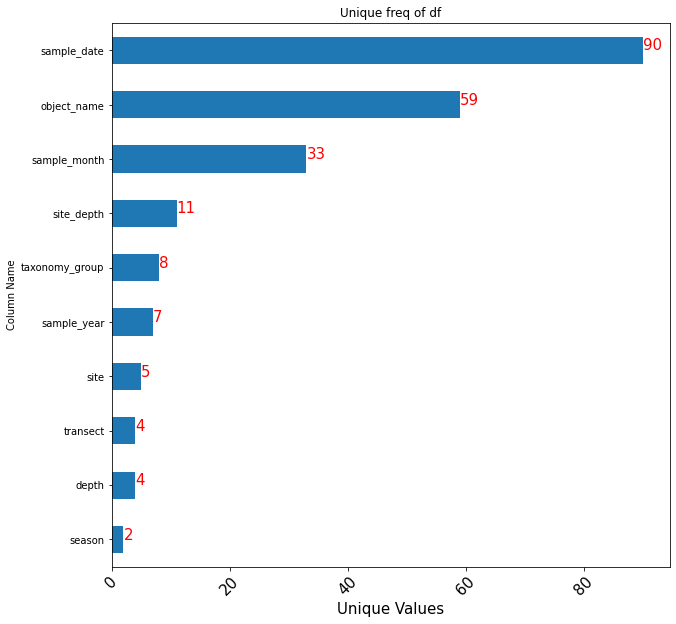

In [ ]:
from matplotlib.pyplot import figure

paint = photo_s_all[['site_depth', 'season', 'depth', 'sample_date'	, 'transect' , 'object_name' , 'taxonomy_group', 'sample_year', 'sample_month' ,'site']].nunique().sort_values()

rows = paint.count()
cols = 1

fig, ax = plt.pyplot.subplots()
#plt.pyplot.tight_layout()

paint.plot( ylabel = 'Unique values' ,  xlabel = 'Column Name' , fontsize= 15    , ax =ax , kind = 'barh',title = 'Unique freq of df'  ,figsize = (10,10) )

for col in range(cols):
    for i in range(rows):
        ax.annotate(f'{paint.iloc[i]}', xy=(paint.iloc[i] , i) , fontsize = 15 ,color = 'red' ) 
plt.pyplot.xticks(rotation=45, fontsize= 15)
plt.pyplot.yticks(fontsize= 10)
ax.set_xlabel("Unique Values", fontsize = 15)
#plt.pyplot.text( x= x ,y = 2 , s = labels)


Text(0, 0.5, '# of Depth')

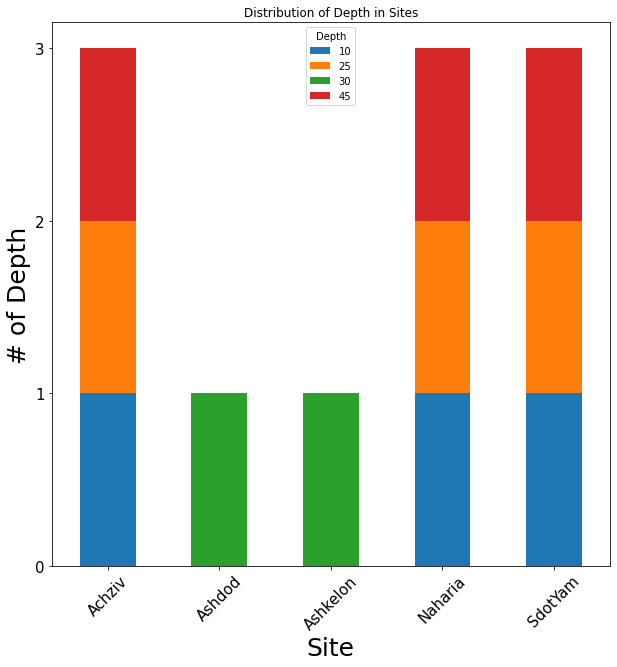

In [ ]:
fig, ax = plt.pyplot.subplots()
photo_s_all.groupby(['site', 'depth'])['depth'].nunique().unstack(fill_value = 0).plot(
         ylabel = '# of Depth' ,kind = 'bar' ,yticks = range(4)
         ,stacked = True , title = "Distribution of Depth in Sites" ,ax =ax   ,figsize = (10,10) 
         ).legend(
         title= 'Depth' ,loc = 'upper center')

plt.pyplot.xticks(rotation=45, fontsize= 15 )
plt.pyplot.yticks(fontsize= 15)
ax.set_xlabel("Site", fontsize = 25)
ax.set_ylabel( '# of Depth', fontsize = 25)

object name - freq pie chart

Text(0.5, 1.0, ' Freq Distribution of Taxonomy Group')

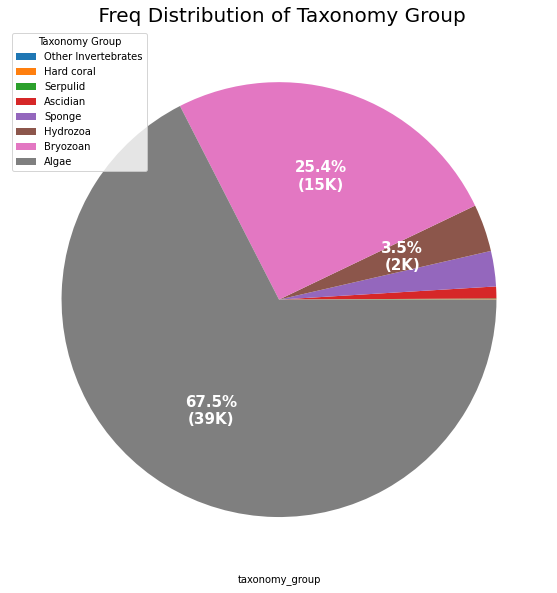

In [ ]:
paint = photo_s_all.groupby(['taxonomy_group'])['freq'].sum().sort_values()
fig, ax = plt.pyplot.subplots()

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals))/1000)
    return f"{pct:.1f}%\n({absolute:d}K)"  if pct > 3 else ''

wedges, texts, autotexts = ax.pie(paint.values, autopct=lambda pct: func(pct, paint.values),
                                  textprops=dict(color="w"))

plt.pyplot.setp(autotexts, size= 15, weight="bold" )

paint.plot(figsize = (10,10) ).legend(
    wedges, list(paint.index),
    title="Taxonomy Group",
    bbox_to_anchor=(0, 1), loc='upper left'
    )
ax.set_title(" Freq Distribution of Taxonomy Group" , fontsize = 20)

Text(0.5, 1.0, 'Organism Diversity by Group')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


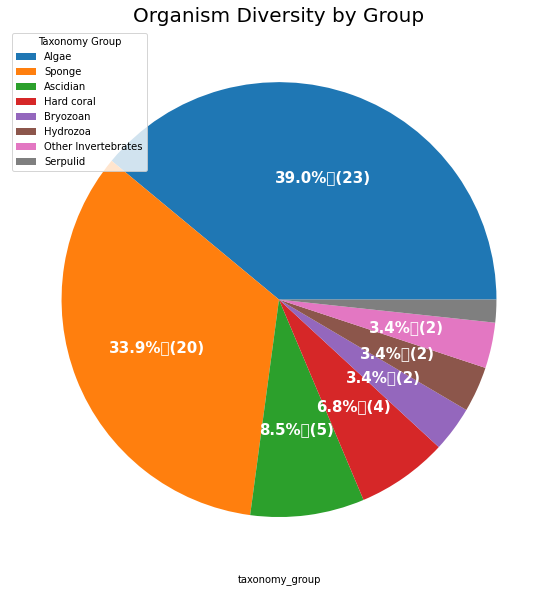

In [ ]:
paint = photo_s_all.groupby(['taxonomy_group'])['object_name'].nunique().sort_values(ascending = False)
fig, ax = plt.pyplot.subplots()

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\t({absolute:d})"  if pct > 3 else ''

wedges, texts, autotexts = ax.pie(paint.values, autopct=lambda pct: func(pct, paint.values),
                                  textprops=dict(color="w"))

plt.pyplot.setp(autotexts, size= 15, weight="bold" )

paint.plot(figsize = (10,10) ).legend(
    wedges, list(paint.index),
    title="Taxonomy Group",
    bbox_to_anchor=(0, 1), loc='upper left'
    )
ax.set_title("Organism Diversity by Group" , fontsize = 20)

Text(0.5, 1.0, ' Freq Distribution of Top 10 Organisms (out of 59)')

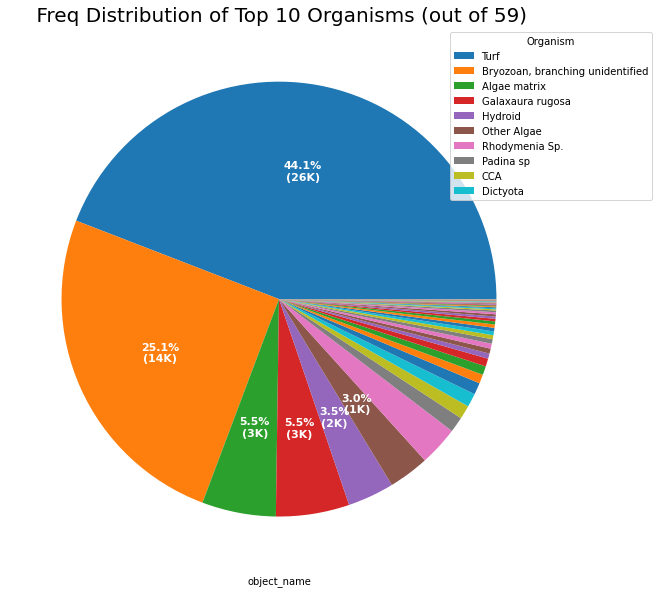

In [ ]:
paint = photo_s_all.groupby(['object_name'])['freq'].sum().sort_values(ascending = False)

fig, ax = plt.pyplot.subplots()

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals))/1000)
    return f"{pct:.1f}%\n({absolute:d}K)"  if pct > 3 else ''

wedges, texts, autotexts = ax.pie(paint.values, autopct=lambda pct: func(pct, paint.values),
                                  textprops=dict(color="w"))

#plt.pyplot.rc('legend',fontsize=12 , title_fontsize = 20 , loc = 'upper left')
plt.pyplot.setp(autotexts, size= 11, weight="bold" )

paint.plot(figsize = (10,10) ).legend(
          wedges, list(paint.index)[0:10],
          title="Organism",
          bbox_to_anchor=(1, 1), loc='upper center'
          )
ax.set_title(" Freq Distribution of Top 10 Organisms (out of 59)" , fontsize = 20) #

In [ ]:
print(photo_s_all.season.unique() )
print(photo_s_all.site.unique() )
print(photo_s_all.depth.unique() )
print(photo_s_all.site_depth.unique() )
print(photo_s_all.site.unique() )

#the unique objects found under each 'taxonomy_group'
tg_len = photo_s[['object_name','taxonomy_group' ]].value_counts().reset_index()
tg_len['taxonomy_group'].value_counts() 

#biases - #Ashdod30 ,Sharon30 and Ashkelon30 has only 1 depth while all other sites have 3 different depth observations(10 , 25 , 45)

['Fall' 'Spring']
['Achziv' 'Ashdod' 'Ashkelon' 'Naharia' 'SdotYam']
[10 25 45 30]
['Achziv10' 'Achziv25' 'Achziv45' 'Ashdod30' 'Ashkelon30' 'Naharia10'
 'Naharia25' 'Naharia45' 'SdotYam10' 'SdotYam25' 'SdotYam45']
['Achziv' 'Ashdod' 'Ashkelon' 'Naharia' 'SdotYam']


Algae                  23
Sponge                 20
Ascidian                5
Hard coral              4
Bryozoan                2
Hydrozoa                2
Other Invertebrates     2
Serpulid                1
Name: taxonomy_group, dtype: int64

##Biased Data

Text(0, 0.5, '# of Sample Dates')

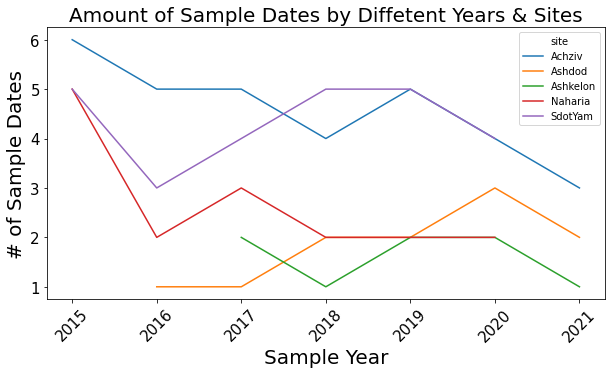

In [ ]:
#how many differemt dates does every site have
fig, ax = plt.pyplot.subplots()
photo_s.groupby(['sample_year' , 'site']).sample_date.nunique().unstack().plot( ax =ax ,figsize = (10,5) )

ax.set_title('Amount of Sample Dates by Diffetent Years & Sites' , fontsize = 20 )
plt.pyplot.xticks(rotation=45, fontsize= 15 )
plt.pyplot.yticks(fontsize= 15)
ax.set_xlabel("Sample Year", fontsize = 20)
ax.set_ylabel( '# of Sample Dates', fontsize = 20)

Text(0, 0.5, '# of Depth')

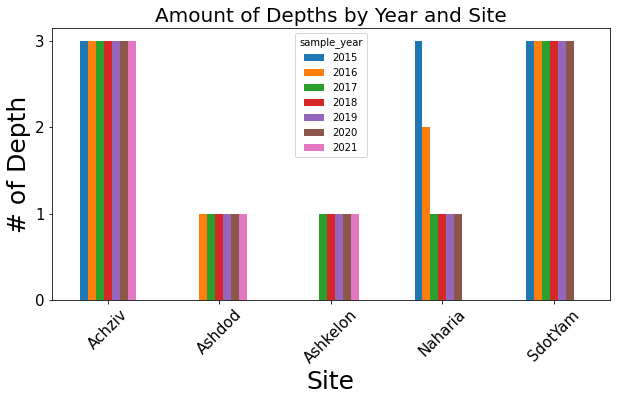

In [ ]:
fig, ax = plt.pyplot.subplots()
photo_s_all.groupby([ 'site' ,'sample_year'])['depth'].nunique().unstack(fill_value = 0).plot(kind = 'bar' , ax =ax ,figsize = (10,5) ,yticks = range(4))

ax.set_title('Amount of Depths by Year and Site' , fontsize = 20 )
plt.pyplot.xticks(rotation=45, fontsize= 15 )
plt.pyplot.yticks(fontsize= 15)
ax.set_xlabel("Site", fontsize = 25)
ax.set_ylabel( '# of Depth', fontsize = 25)

Unique Dates by Year , Site & Depth

Text(0, 0.5, '# unique dates')

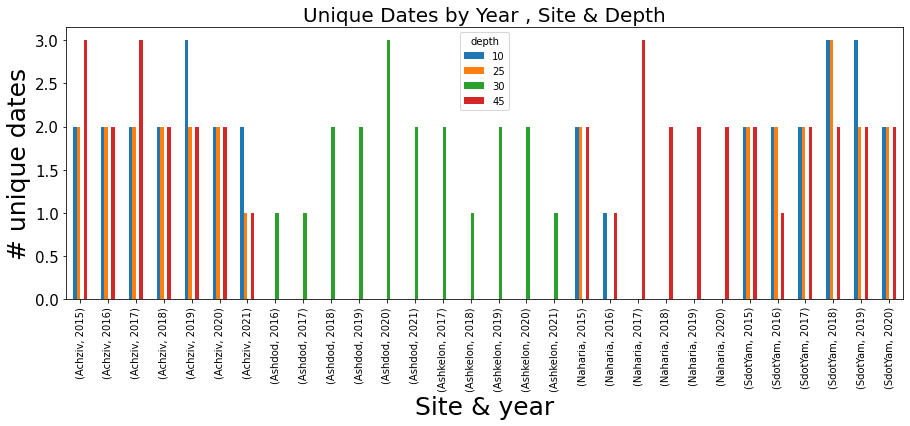

In [ ]:
fig, ax = plt.pyplot.subplots()
paint = photo_s_all.groupby([ 'site' ,'sample_year' ,'depth'])['sample_date'].nunique().unstack(fill_value = 0)
paint.plot(kind = 'bar' , ax =ax ,figsize = (15,5)   )

ax.set_title('Unique Dates by Year , Site & Depth' , fontsize = 20 )
plt.pyplot.yticks(fontsize= 15)
ax.set_xlabel("Site & year", fontsize = 25)
ax.set_ylabel( '# unique dates', fontsize = 25)


##Pearson correlation

In [ ]:
from ast import NodeTransformer
df = photo_s_all.groupby(['site_depth', 'sample_date','object_name'])['freq'].sum()
df = df.unstack(fill_value = 0)
df_corr = df.corr('pearson')
#one way
print( df_corr.values[ df_corr.values < 1].max() )
print(df_corr.values[ df_corr.values < 1].min())
#second way
#(df_corr[ df_corr <1 ].max() )#.min()

#check whcich objects have high corrlation :
param = 0.7
m = df_corr[ ( (df_corr > param) & (df_corr < 1) ) | ( (df_corr > -1 ) & (df_corr < - param ) )  ]
m.dropna( axis = 0 , how = 'all' , inplace = True) #NaN
m.dropna( axis = 1 , how = 'all' , inplace = True) 
#m['Aglaophenia spp.'].max()
m


0.9437452633645077
-0.6389009428311572


object_name,Botryocladia Sp.,Cerianthus sp.,Codium,Ircinia dendroides,Mycale spp.,Padina sp,Petrosia ficiformis
object_name,,,,,,,
Botryocladia Sp.,NaN,NaN,NaN,0.813296,0.869020,NaN,NaN
Cerianthus sp.,NaN,NaN,NaN,NaN,NaN,NaN,0.774004
Codium,NaN,NaN,NaN,NaN,NaN,0.776436,NaN
Ircinia dendroides,0.813296,NaN,NaN,NaN,0.943745,NaN,NaN
Mycale spp.,0.869020,NaN,NaN,0.943745,NaN,NaN,NaN
Padina sp,NaN,NaN,0.776436,NaN,NaN,NaN,NaN
Petrosia ficiformis,NaN,0.774004,NaN,NaN,NaN,NaN,NaN


##Heat Map

In [ ]:
#corrlation heat map
fig = px.imshow(m,height=750 ,width=750 )
fig.show()

show corrlation in list

In [ ]:
arr = m.reset_index().to_numpy()
#create list of tuples in the form of #(corr1 ,corr2 ,Value)
list_tup = []
for i in range( len(arr) ):
    list_tup.append( [ (arr[i][0] , arr[j,0] , arr[i,j+1] ) for j in range( len(arr[i])-2 ) if arr[i,j+1] == arr[i,j+1] ] ) #* if arr[i,j+1] == arr[i,j+1] if the value is not None

import itertools
#flat list_tup to one list of tuples
merged = list(itertools.chain(*list_tup))
merged

[('Botryocladia Sp.', 'Ircinia dendroides', 0.813295989849019),
 ('Botryocladia Sp.', 'Mycale spp.', 0.8690199200407277),
 ('Codium', 'Padina sp', 0.7764356499803101),
 ('Ircinia dendroides', 'Botryocladia Sp.', 0.813295989849019),
 ('Ircinia dendroides', 'Mycale spp.', 0.9437452633645077),
 ('Mycale spp.', 'Botryocladia Sp.', 0.8690199200407277),
 ('Mycale spp.', 'Ircinia dendroides', 0.9437452633645077),
 ('Padina sp', 'Codium', 0.7764356499803101),
 ('Petrosia ficiformis', 'Cerianthus sp.', 0.7740040295028506)]

In [ ]:
#try to find if the high corrlations related to taxonomy_group
map_group = photo_s_all[['object_name','taxonomy_group']].value_counts()
map_group = map_group.reset_index()
map_group.drop(columns = [0], axis =1 , inplace = True)
#[ (map_group[obj[0]] , map_group[obj[1]] ) for obj in merged  ]
for obj in merged :
    print( ( map_group['taxonomy_group'][map_group.object_name == obj[0]  ].max(), map_group['taxonomy_group'][map_group.object_name == obj[1] ].max()) )
    print(f'{obj} \n')

('Algae', 'Sponge')
('Botryocladia Sp.', 'Ircinia dendroides', 0.8132959898490173) 

('Algae', 'Algae')
('Botryocladia Sp.', 'Mycale spp.', 0.8690199200407319) 

('Other Invertebrates', 'Sponge')
('Cerianthus sp.', 'Petrosia ficiformis', 0.7740040295028509) 

('Algae', 'Other')
('Codium', 'Cyanobacteria films', 0.7168287313692153) 

('Algae', 'Algae')
('Codium', 'Padina sp', 0.776435649980309) 

('Other', 'Algae')
('Cyanobacteria films', 'Codium', 0.7168287313692153) 

('Other', 'Bryozoan')
('Cyanobacteria films', 'Schizoporella sp.', 0.7238861428703798) 

('Sponge', 'Algae')
('Ircinia dendroides', 'Botryocladia Sp.', 0.8132959898490173) 

('Sponge', 'Algae')
('Ircinia dendroides', 'Mycale spp.', 0.9437452633645087) 

('Algae', 'Algae')
('Mycale spp.', 'Botryocladia Sp.', 0.8690199200407319) 

('Algae', 'Sponge')
('Mycale spp.', 'Ircinia dendroides', 0.9437452633645087) 

('Algae', 'Algae')
('Padina sp', 'Codium', 0.776435649980309) 

('Sponge', 'Other Invertebrates')
('Petrosia ficifo

##Diversity Analysis (unique object sampling)

create unique data frame - 'photo_s'

drop duplicates

In [ ]:
photo_s.drop_duplicates(keep = 'first' , inplace= True)
ser = photo_s.value_counts()
ser[ser.values == 1].count()

11947

Create unique dataframe per year and site - evry row represnt if the object appeared in the specified year and site

In [ ]:
#transform df to have unique rows in the form of : site , date , fish name , taxonomy_group ,year ,season
photo_s.drop( columns = ['image_name', 'transect' , 'depth','site_depth'] ,inplace = True)
photo_s.drop_duplicates(keep = 'first' , inplace= True)

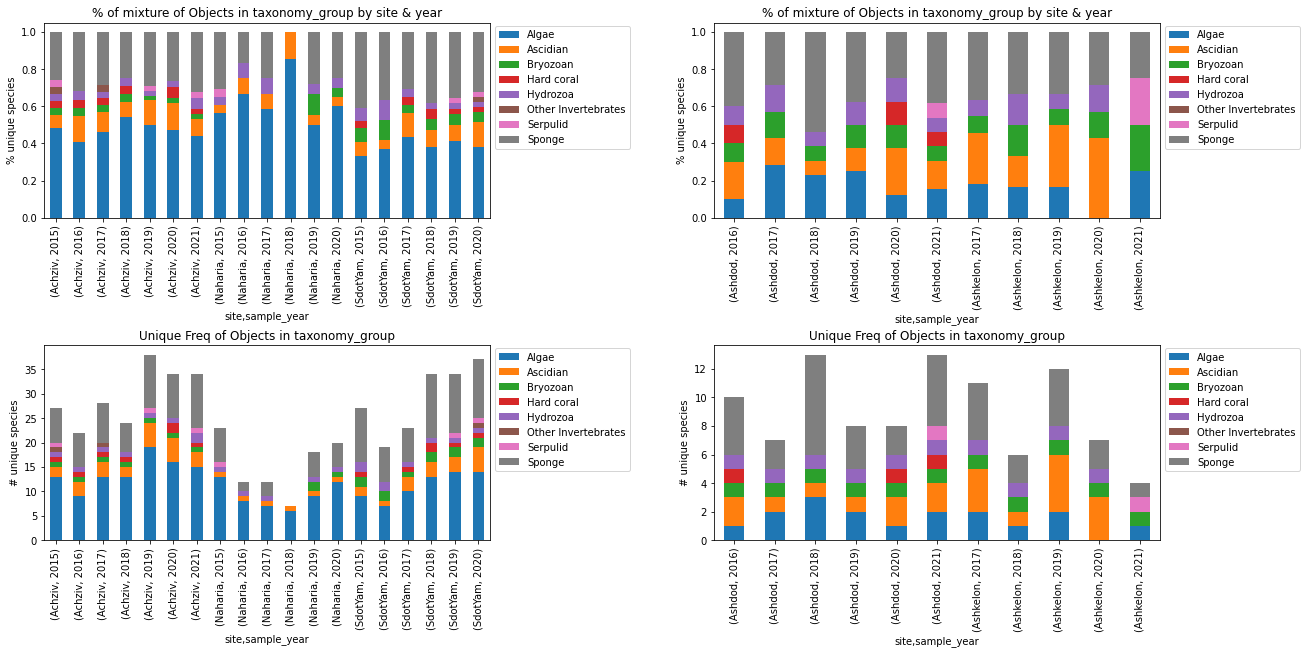

In [ ]:
#Create a unique df - for evry 'site', 'sample_year' & taxonomy_group count object_name only once
test = photo_s[[ 'site', 'sample_year'  ,'taxonomy_group','object_name' ]].value_counts()

test[:] = 1
temp = test.reset_index()
temp.rename( {0: 'unique_objects'} , axis = 1 , inplace = True)
temp2 = temp[[ 'site', 'sample_year'  ,'taxonomy_group' ]].value_counts()

#pivot
temp2 = temp2.unstack(fill_value = 0) 
# for every row divide the the column by the sum of the column values to get % of row
temp2_p = temp2.div( temp2.sum(axis = 1) , axis = 0)

#plot
fig, axes = plt.pyplot.subplots(nrows=2, ncols=2 ,sharex=True)
#create space between two graphs
fig.tight_layout(pad=3.0)

ax_1 = temp2_p[~temp2_p.index.isin(['Ashkelon', 'Ashdod'], level=0)] #not in 'Ashkelon', 'Ashdod'
ax_2 = temp2_p[temp2_p.index.isin(['Ashkelon', 'Ashdod'], level=0)]

#unique distribution
plt1 = ax_1.plot( ylabel = '% unique species' ,kind = 'bar', stacked = True, title = '% of mixture of Objects in taxonomy_group by site & year' ,ax = axes[0,0]  ,figsize = (20,20) )
plt1.legend(bbox_to_anchor=(1, 1.01), loc='upper left')
plt2 = ax_2.plot( ylabel = '% unique species', kind = 'bar', stacked = True, title = '% of mixture of Objects in taxonomy_group by site & year' ,ax = axes[0,1]  ,figsize = (20,10) ).legend(bbox_to_anchor=(1, 1.01), loc='upper left')

#unique freq
ax_1 =  temp2[~temp2_p.index.isin(['Ashkelon', 'Ashdod'], level=0)] #not in 'Ashkelon', 'Ashdod'
ax_2 = temp2[temp2_p.index.isin(['Ashkelon', 'Ashdod'], level=0)]

ax_1.plot( ylabel = '# unique species' , kind = 'bar', stacked = True, title = 'Unique Freq of Objects in taxonomy_group' ,ax = axes[1,0]  ,figsize = (20,20)  ).legend(bbox_to_anchor=(1, 1.01), loc='upper left')
ax_2.plot( ylabel = '# unique species', kind = 'bar', stacked = True, title = 'Unique Freq of Objects in taxonomy_group' ,ax = axes[1,1]  ,figsize = (20,10)  ).legend(bbox_to_anchor=(1, 1.01), loc='upper left')

#in the plots bellow we can see that there are differences in the mixture of objects between sites.
#there is also disapering of 'Algae' (taxonomy_group) in Ashkelon in 2020 . 
#Ashdod 2018 - much more % of sponge

#does there is difference in the divercity between sites ?(does one place have spcice that not appear in the other sites ?)
#in the second plot we can see that achziv and sdot yam sites have greater divercity of obects (absulte number), we belive this is bias data , because achziv and sdot yam have much more data points  
    #, the data thier have been collect in different depth while in Ashkelon and Ashdod there is only one depth.

#subplot for different column .plot( subplots=True, layout=(5,5) )

##Season

Is the Season effect the number of Organism in sea ? 

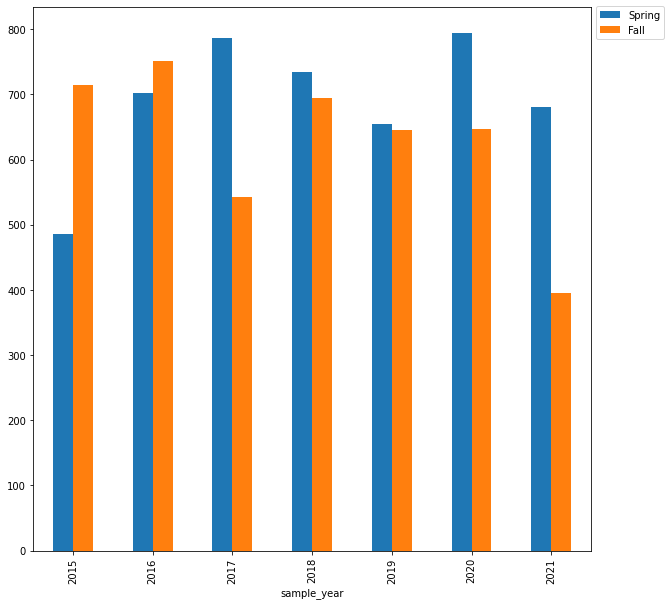

In [ ]:
###daily avg amount
df = photo_s_all.groupby(['sample_year', 'season']).agg( 
  pie
df['daily_avg'] = (df.freq / df.unique_dates ).round(decimals = 2)
df = df['daily_avg'].unstack( fill_value = 0 ).sort_index(axis =1 ,ascending = False)
df.plot(kind = 'bar' ,stacked = False, figsize = (10,10) ).legend(bbox_to_anchor=(1, 1.01), loc='upper left')


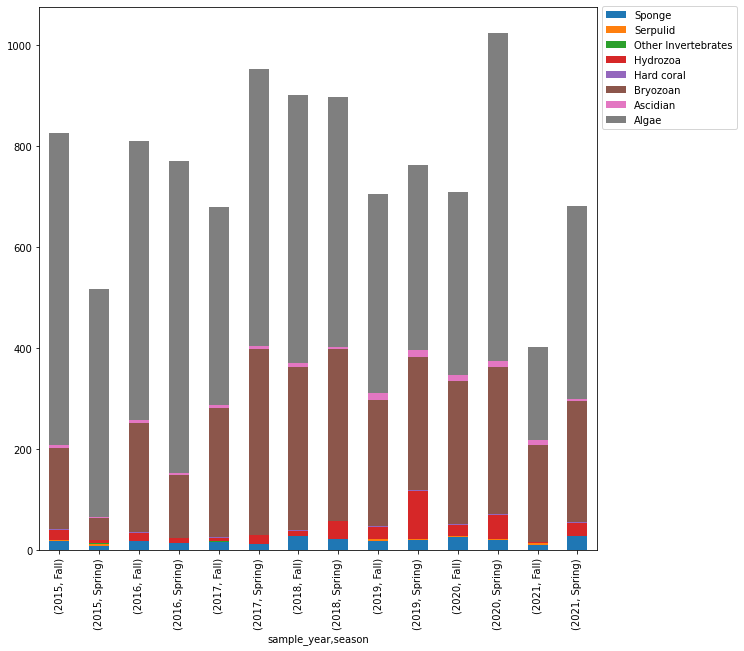

In [ ]:
###daily avg amount
df = photo_s_all.groupby(['sample_year', 'season','taxonomy_group']).agg( 
    freq = pd.NamedAgg(column= 'freq', aggfunc= 'sum'),  
    unique_dates = pd.NamedAgg(column= 'sample_date', aggfunc= 'nunique') )
df['daily_avg'] = (df.freq / df.unique_dates ).round(decimals = 2)
df = df['daily_avg'].unstack( fill_value = 0 ).sort_index(axis =1 ,ascending = False)
df.plot(kind = 'bar' ,stacked = True, figsize = (10,10) ).legend(bbox_to_anchor=(1, 1.01), loc='upper left')


#**Fish Survey Analysis**

##Prepare Data

Add\Drop columns & Rows

In [ ]:
fs.drop(columns= ['taxonomy_group','habitat','observer','depth'] , inplace = True)
fs['s_ymonth'] = fs.sample_date.dt.strftime('%Y-%m')
fs['s_month'] = fs.sample_date.dt.strftime('%m')
#fs['s_month']

In [ ]:
#filter Ashdod & Ashkelon
fs = fs[~fs.site.isin(["Ashdod" ,"Ashkelon"])]
#specie variety
fs = fs.groupby(['site_id','s_ymonth']).species.value_counts().unstack(fill_value=0)
fs["sum"] = fs.sum(axis=1)
#just to test the sum is correct.. 
fs.iloc[0].sum()

62

Create Propotinal df of Species per Date & Site

In [ ]:
s_rel = fs.iloc[:,1:].div(fs['sum'], axis=0)
s_rel.head()

species            Argyrosomus regius  Atherinomorus forskalii  \
site_id  s_ymonth                                                
Achziv10 2015-04                  0.0                      0.0   
         2015-11                  0.0                      0.0   
         2016-05                  0.0                      0.0   
         2017-05                  0.0                      0.0   
         2017-11                  0.0                      0.0   

species            Balistes capriscus  Carcharhinus plumbeus  Chromis chromis  \
site_id  s_ymonth                                                               
Achziv10 2015-04                  0.0                    0.0         0.516129   
         2015-11                  0.0                    0.0         0.408964   
         2016-05                  0.0                    0.0         0.554585   
         2017-05                  0.0                    0.0         0.730038   
         2017-11                  0.0                    0.0         0.531056   

species            Coris julis  Dasyatis pastinaca  Dasyatis sp  \
site_id  s_ymonth                                                 
Achziv10 2015-04      0.032258                 0.0          0.0   
         2015-11      0.042017                 0.0          0.0   
         2016-05      0.126638                 0.0          0.0   
         2017-05      0.038023                 0.0          0.0   
         2017-11      0.027950                 0.0          0.0   

species            Diplodos cervinus  Diplodus cervinus  ...  Siganus sp  \
site_id  s_ymonth                                        ...               
Achziv10 2015-04                 0.0                0.0  ...         0.0   
         2015-11                 0.0                0.0  ...         0.0   
         2016-05                 0.0                0.0  ...         0.0   
         2017-05                 0.0                0.0  ...         0.0   
         2017-11                 0.0                0.0  ...         0.0   

species            Sparisoma cretense  Symphodus mediterraneus  Symphodus sp  \
site_id  s_ymonth                                                              
Achziv10 2015-04             0.000000                      0.0           0.0   
         2015-11             0.000000                      0.0           0.0   
         2016-05             0.000000                      0.0           0.0   
         2017-05             0.000000                      0.0           0.0   
         2017-11             0.001035                      0.0           0.0   

species            Symphodus tinca  Synodus saurus  Taeniurops grabatus  \
site_id  s_ymonth                                                         
Achziv10 2015-04               0.0             0.0             0.000000   
         2015-11               0.0             0.0             0.000000   
         2016-05               0.0             0.0             0.000000   
         2017-05               0.0             0.0             0.000000   
         2017-11               0.0             0.0             0.001035   

species            Thalassoma pavo  Torquigener flavimaculosus  sum  
site_id  s_ymonth                                                    
Achziv10 2015-04          0.225806                    0.000000  1.0  
         2015-11          0.086835                    0.000000  1.0  
         2016-05          0.074236                    0.000000  1.0  
         2017-05          0.140684                    0.011407  1.0  
         2017-11          0.025880                    0.004141  1.0  

[5 rows x 52 columns]

##Population Distribution

###Achziv Population Distribution

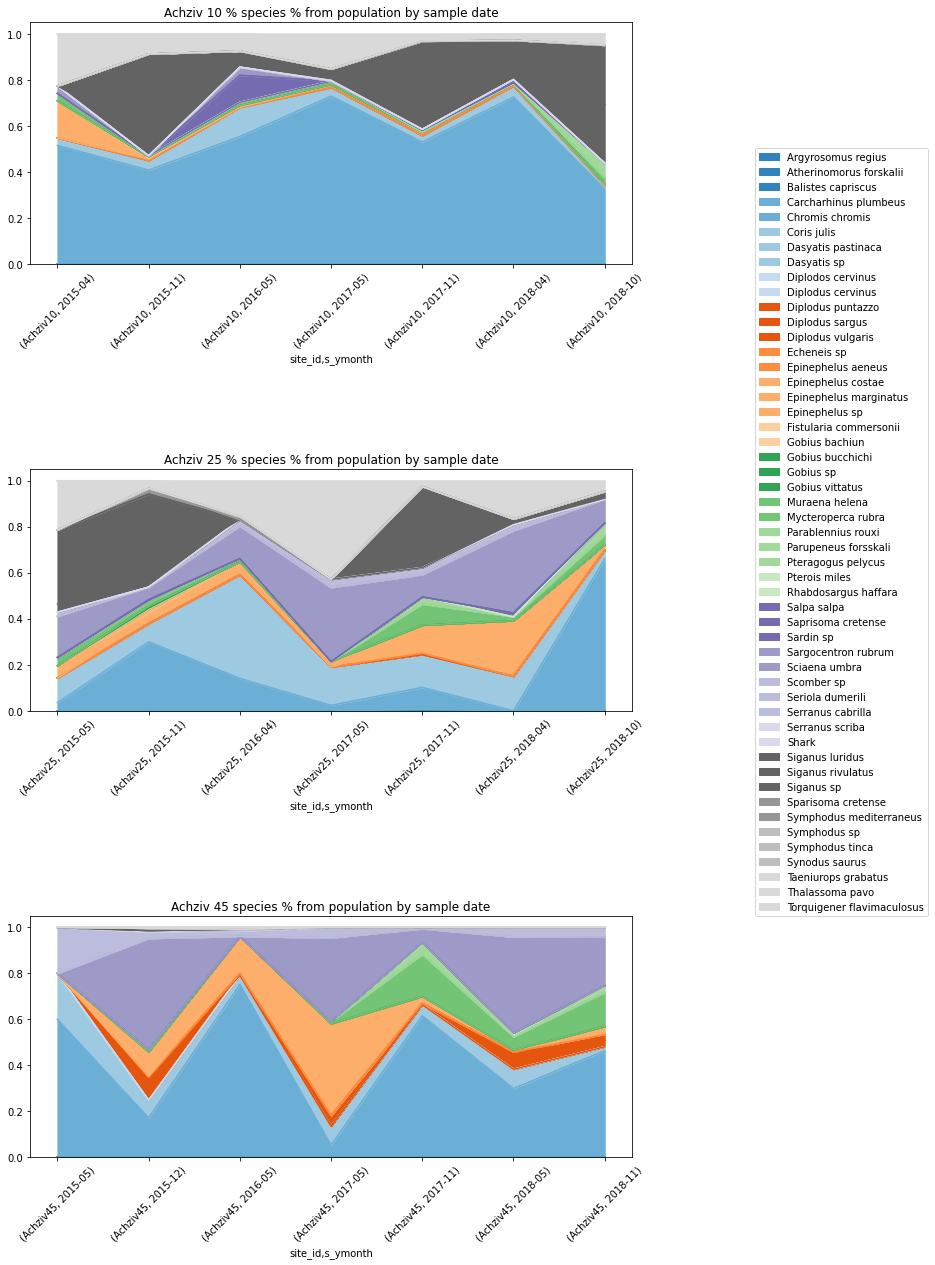

In [ ]:
#Achziv population distribution

fig, axes = plt.subplots(nrows=3)
# #create space between two graphs
fig.tight_layout(pad=2)
fre = s_rel.drop(columns= 'sum', inplace = False)  #without sum column
# fre = fre.droplevel(level = 0) # i tried to drop the site_id index
#Achziv 10,25,45
ax_a10 = fre[fre.index.isin(['Achziv10'], level=0)]
ax_a25 = fre[fre.index.isin(['Achziv25'], level=0)]
ax_a45 = fre[fre.index.isin(['Achziv45'], level=0)]


s_rel.reset_index().set_index('s_ymonth')

#unique distribution 10,25,45 Ach
plt1 = ax_a10.plot( kind = 'area', stacked = True, title = 'Achziv 10 % species % from population by sample date' , cmap='tab20c',ax = axes[0]  ,figsize = (10,20) , rot=45)
plt1.legend(bbox_to_anchor=(1, 0, 0.5, 0.5), loc='best')
plt2 = ax_a25.plot( kind = 'area', stacked = True, title = 'Achziv 25 % species % from population by sample date' ,cmap='tab20c', ax = axes[1] ,figsize = (10,20), rot=45 )
plt2.legend(bbox_to_anchor=(0, 1.01), loc='upper left')
plt3 = ax_a45.plot( kind = 'area', stacked = True, title = 'Achziv 45 species % from population by sample date' ,cmap='tab20c',ax = axes[2]  ,figsize = (10,20), rot=45 )
plt3.legend(bbox_to_anchor=(0, 1.01), loc='upper left')
plt2.get_legend().remove()
plt3.get_legend().remove()
# plt1.subplots_adjust(left=1.5)
plt.savefig('Achziv.png',bbox_inches='tight')


###Naharia Population Distribution

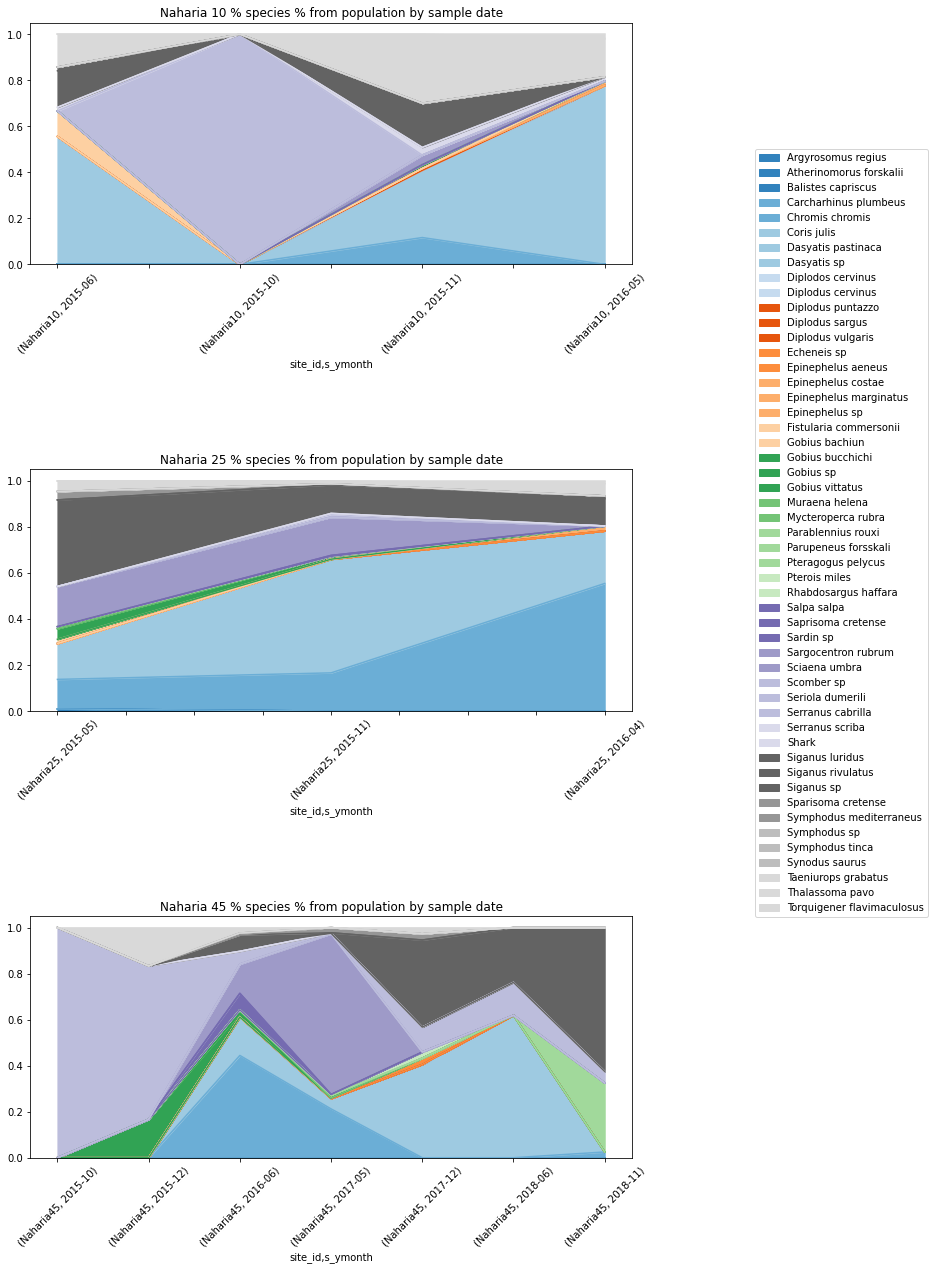

In [ ]:
#unique distribution 10,25,45 Naharia
fig, axes = plt.subplots( nrows =  3)
#create space between two graphs
fig.tight_layout(pad=2.0)
fre = s_rel.drop(columns= 'sum', inplace = False)

#Naharia 10,25,45
ax_n10 = fre[fre.index.isin(['Naharia10'], level=0)]
ax_n25 = fre[fre.index.isin(['Naharia25'], level=0)]
ax_n45 = fre[fre.index.isin(['Naharia45'], level=0)]
#define
plt4 = ax_n10.plot( kind = 'area', stacked = True, title = 'Naharia 10 % species % from population by sample date' ,cmap='tab20c', ax = axes[0]  ,figsize = (10,20) , rot=45 )
plt5 = ax_n25.plot( kind = 'area', stacked = True, title = 'Naharia 25 % species % from population by sample date' ,cmap='tab20c', ax = axes[1]  ,figsize = (10,20) , rot=45 )
plt6 = ax_n45.plot( kind = 'area', stacked = True, title = 'Naharia 45 % species % from population by sample date' ,cmap='tab20c', ax = axes[2]  ,figsize = (10,20) , rot=45 )
#plot
plt4.legend(bbox_to_anchor=(1, 0, 0.5, 0.5), loc='best')
plt5.legend(bbox_to_anchor=(1, 0, 0.5, 0.5), loc='best')
plt6.legend(bbox_to_anchor=(1, 0, 0.5, 0.5), loc='best')
#legend remove
plt5.get_legend().remove()
plt6.get_legend().remove()
plt.savefig('Naharia1.png')


###Sdot Yam Population Distribution

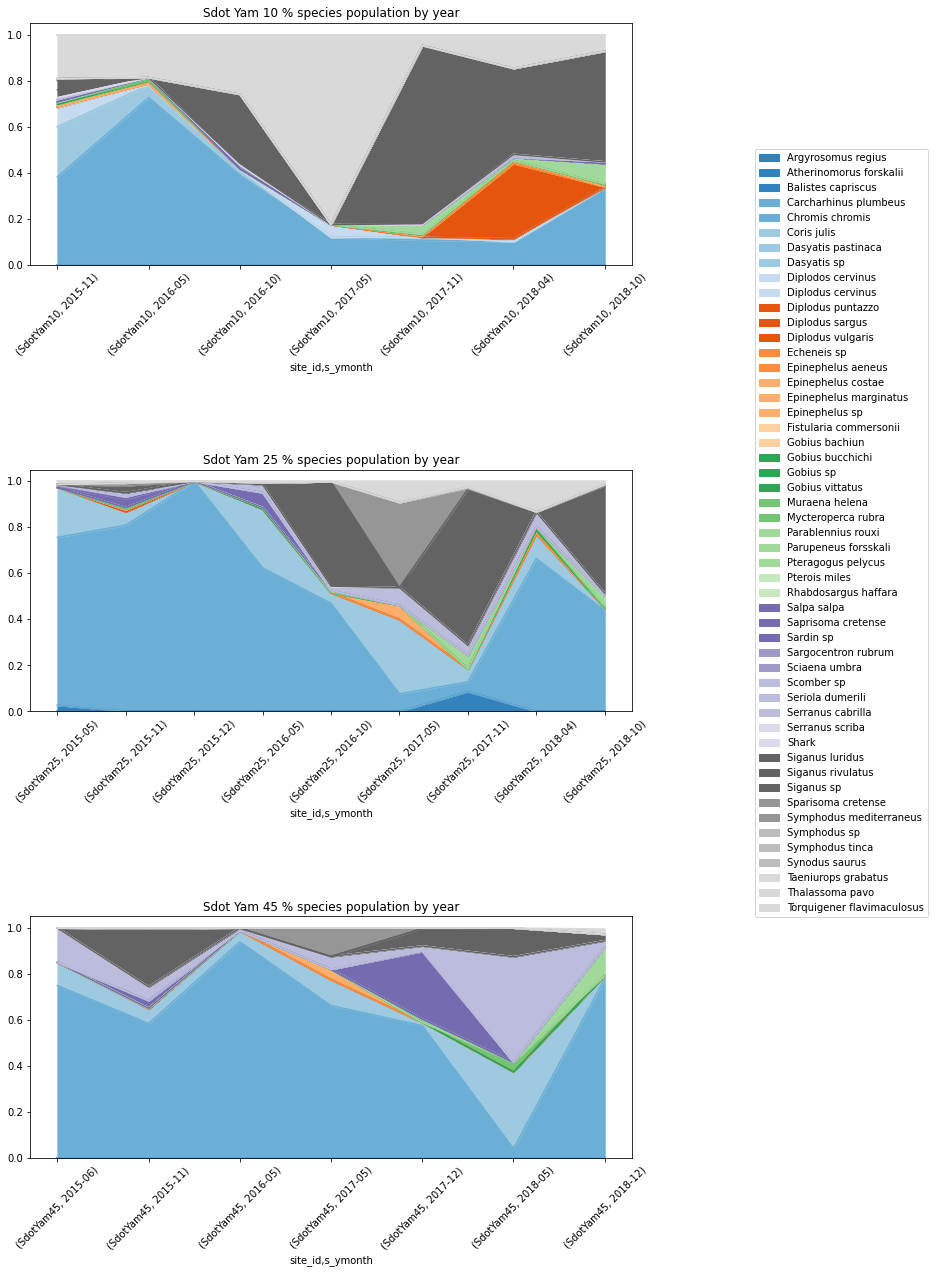

In [ ]:
# unique distribution 10,25,45 Sdot
fig, axes = plt.subplots( nrows =  3)
fig.tight_layout(pad=2)
#Sdot Yam 10,25,45
fre = s_rel.drop(columns= 'sum', inplace = False) #s_rel = spiecies distribution in % within all sites, df indexed by site and sample month
ax_s10 = fre[fre.index.isin(['SdotYam10'], level=0)]
ax_s25 = fre[fre.index.isin(['SdotYam25'], level=0)]
ax_s45 = fre[fre.index.isin(['SdotYam45'], level=0)]
#define
plt7 = ax_s10.plot( kind = 'area', stacked = True, title = 'Sdot Yam 10 % species population by year' ,cmap='tab20c',ax = axes[0]  ,figsize = (10,20) , rot=45 )
plt8 = ax_s25.plot( kind = 'area', stacked = True, title = 'Sdot Yam 25 % species population by year' ,cmap='tab20c',ax = axes[1]  ,figsize = (10,20) , rot=45 )
plt9 = ax_s45.plot( kind = 'area', stacked = True, title = 'Sdot Yam 45 % species population by year' ,cmap='tab20c',ax = axes[2]  ,figsize = (10,20) , rot=45 )
#plot
plt7.legend(bbox_to_anchor=(1, 0, 0.5, 0.5), loc='best')
plt8.legend(bbox_to_anchor=(1, 0, 0.5, 0.5), loc='best')
plt9.legend(bbox_to_anchor=(1, 0, 0.5, 0.5), loc='best')
#legend remove
plt8.get_legend().remove()
plt9.get_legend().remove()
plt.savefig('SdotYam1.png')


##PSI - Population Stability Index

###What is the population stability index (PSI)?


PSI is a measure of how much a population has shifted over time or between two different samples of a population in a single number. 

It does this by bucketing the two distributions and comparing the percents of items in each of the buckets, resulting in a single number you can use to understand how different the populations are. The common interpretations of the PSI result are:

PSI < 0.1: no significant population change

PSI < 0.2: moderate population change

PSI >= 0.2: significant population change

###Calculate PSI Function

In [ ]:
###func vvvv
def calc_PSI(df ,site_depth):

    df = df[df.index.isin([str(site_depth)], level=0)]
    #deltas between sampl dates
    diff = df.diff(axis=0,);
    diff.fillna(0,inplace=True)

    #removing firs line of df, round to 4 decimal points 
    diff_  = diff.iloc[1: , :]
    #diff_.drop(columns= 'sum', inplace = True)
    diff_.round(6)

    # Prepring the data 
    last_  = df.iloc[1: , :]
    df2 = df
    df2 = df2.reset_index(drop=True)
    last_ = last_.reset_index(drop=True)
    df2.fillna(0,inplace=True)
    last_.fillna(0,inplace=True)
    diff_ = diff_.reset_index(drop=True)
    div_ = last_/df2
    div_.replace([np.inf, -np.inf], np.nan, inplace=True)
    div_.fillna(0,inplace=True)
    div_ = div_.iloc[:6 , :]

    # df['PSI'] = (df['New Percent'] - df['Initial Percent']) * np.log(df['New Percent'] / df['Initial Percent'])
    PSI = diff_ * (np.log(div_))
    PSI.replace([np.inf, -np.inf], np.nan, inplace=True)
    PSI.fillna(0,inplace=True)
    PSI = PSI.replace(0, np.NaN)

    #PSI - final result per site!!
    PSI_Value = round(PSI.mean().mean() ,4 )

    ## define PSI_Cat
    if PSI_Value <= 0.1:
        PSI_Cat = 'Not Significant'
    elif PSI_Value >= 0.2:
        PSI_Cat = 'significant'
    else:
     PSI_Cat = 'Moderate'

    return (PSI_Value , PSI_Cat)

Run function on all sites

In [ ]:
#### source df is --> s_rel.drop(columns= 'sum', inplace = False)  #without sum column
df = s_rel.drop(columns= 'sum', inplace = False)
site_d_list = list(df.index.levels[0])

for site in site_d_list:
    print(f'{site} ,  PSI Score:' ,calc_PSI(df ,site) )

Achziv10 ,  PSI Score: (0.0765, 'Not Significant')
Achziv25 ,  PSI Score: (0.1317, 'Moderate')
Achziv45 ,  PSI Score: (0.1994, 'Moderate')
Naharia10 ,  PSI Score: (0.1955, 'Moderate')
Naharia25 ,  PSI Score: (0.1126, 'Moderate')
Naharia45 ,  PSI Score: (0.3712, 'significant')
SdotYam10 ,  PSI Score: (0.2024, 'significant')
SdotYam25 ,  PSI Score: (0.3375, 'significant')
SdotYam45 ,  PSI Score: (0.4115, 'significant')
